# Motivation
There are many times we may want to do multiple comparisons. In my time working in Supply Chain we were often asked to find SKUs that had sharp changes in demand. This was particularly important when SKUs had downward shifts in demand. Since service levels are the inventory analogue to percentiles, and we used years' of sales history, we could be overstocking for a while!

# The approach
A typical way to check to see if the mean has changed is to use a t-test. This is fine if you are comparing two sets and the distribution is normal-ish (mound shaped).


### Can we just do a t-test multiple times?
Well, that's sort of what we'll do! There are some caveats though. 
1. The multiple comparisons problem is a big deal. 
2. These observations aren't independent
3. A Bonferroni correction is going to severely limit our statistical power in identifying SKUs with lost sales. Based on 2, our p-values are going to be correlated.

In [2]:
#generate random sales data, it has lots of 0s, but has some decent spread when it is non-zero.
#'https://en.wikipedia.org/wiki/Negative_binomial_distribution#Gamma%E2%80%93Poisson_mixture'
#Overdispersed Poisson

#imports
from scipy.stats import nbinom
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import scipy.stats as stats
from time import time

In [8]:
n=.4
p=.2
sales = nbinom.rvs(n, p, size=1000)

(array([797., 130.,  45.,  10.,   7.,   4.,   2.,   3.,   1.,   1.]),
 array([ 0. ,  2.7,  5.4,  8.1, 10.8, 13.5, 16.2, 18.9, 21.6, 24.3, 27. ]),
 <a list of 10 Patch objects>)

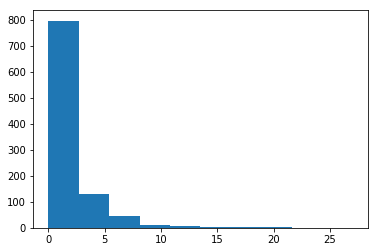

In [9]:
plt.hist(sales)

# Base case

## For a specific Item - Loc get 26 weeks of sales history

In [34]:
sales = nbinom.rvs(n, p, size=26)

In [35]:
sales

array([2, 0, 0, 0, 0, 4, 0, 0, 3, 0, 4, 4, 4, 3, 0, 0, 0, 0, 0, 0, 0, 0,
       3, 1, 0, 3])

## do a 13 week over 13 week comparison

In [72]:
rvs1 = sales[:13]
rvs2 = sales[13:]
print('we have a p-value of: ' + str(stats.ttest_ind(rvs1,rvs2).pvalue))

we have a p-value of: 0.05366034071650955


In [42]:
str(stats.ttest_ind(rvs1,rvs2).pvalue)

'0.19684796677095295'

# Now let's simulate this a few thousand times. We should expect our p-value to be $\leq.05$ around $5\%$ of the time

In [63]:
p_values = []
for x in range(10000):
    rvs1 = nbinom.rvs(n, p, size=13)
    rvs2 = nbinom.rvs(n, p, size=13)
    p_values.append(stats.ttest_ind(rvs1,rvs2).pvalue)
    

## A histogram of our distribution of p-values. Looks Uniform, great!

(array([ 995., 1019.,  966.,  981.,  983., 1052., 1017., 1042.,  964.,
         981.]),
 array([2.10121370e-05, 1.00016862e-01, 2.00012712e-01, 3.00008562e-01,
        4.00004412e-01, 5.00000262e-01, 5.99996112e-01, 6.99991962e-01,
        7.99987812e-01, 8.99983662e-01, 9.99979512e-01]),
 <a list of 10 Patch objects>)

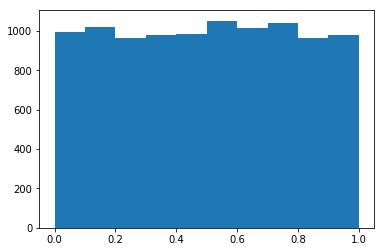

In [67]:
plt.hist(p_values)

In [68]:
np.mean(np.array(p_values)<.05)

0.0479

## If we run this a few more times, we see this is actually around 4% instead of 5%. I'd conjecture it's because a t-test works best with the normal distribution and our data is not normally distributed. Let's validate this with a standard normal...

0.0517

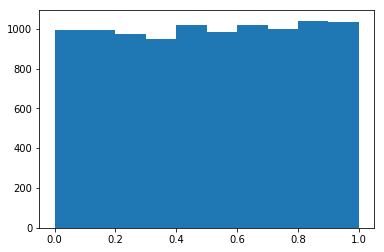

In [71]:
p_values = []
for x in range(10000):
    rvs1 = stats.norm.rvs(0, 1, size=13)
    rvs2 = stats.norm.rvs(0, 1, size=13)
    p_values.append(stats.ttest_ind(rvs1,rvs2).pvalue)
plt.hist(p_values)
np.mean(np.array(p_values)<.05)

# Get rolling sales history for 27 weeks now doing 2 comparisons. The first 13 weeks vs. 2nd 13 weeks. And weeks 2-14 vs. weeks 15-27.

In [210]:
#first 13 week over 13 week comparison
first_comparison_pvals = []
second_comparison_pvals = []
for x in range(10000):
    sales = stats.nbinom.rvs(n, p, size=27)
    c1rvs1 = sales[:13]
    c1rvs2 = sales[13:26]
    c1p = stats.ttest_ind(c1rvs1,c1rvs2).pvalue
    first_comparison_pvals.append(c1p)

    c2rvs1 = sales[1:14]
    c2rvs2 = sales[14:27]
    c2p = stats.ttest_ind(c2rvs1,c2rvs2).pvalue
    second_comparison_pvals.append(c2p)
    

In [211]:
(np.array(first_comparison_pvals)<.05).sum(), (np.array(second_comparison_pvals)<.05).sum()

(362, 356)

In [212]:
((np.array(first_comparison_pvals)<.05)|(np.array(second_comparison_pvals)<.05)).sum()

527

0.0527

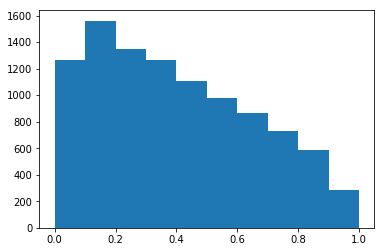

In [213]:
minp = np.minimum(np.array(first_comparison_pvals), np.array(second_comparison_pvals))
plt.hist(minp)
np.mean(np.array(minp)<.05)

## Notice the chart looks different now.
 1. Our min-p value distribution is no longer flat. We don't want this. 
 2. Also, this p-value is a function of several variables now. We don't want to engineer our pooled p-value. We want instead to specify a pooled p-value, and find the right threshold for component p-values. We can use a quantile function to do this.

 Let's suppose we want a p-value of .05. Now let's simulate it.
 To do this we find the 5th percentile of our min of comparisons, minp


In [214]:
significance_threshold = np.percentile(minp,5)

In [215]:
significance_threshold

0.04793628260829048

Our significance threshold is now about 4.8% a much more powerful threshold than using a signifiance threshold of 2.5% if we had a Bonferroni correction.

# Let's generalize this. Let's do a 52 week period, with 27 comparisons of 13 week periods. 
* First comparison is weeks 1-13 vs. 14-26. 
* Second comparison is weeks 2-14 vs. 15-27, 
* ...27th comparison is weeks 27-39 vs. weeks 40-52.

In [160]:
#first 13 week over 13 week comparison
start=time()
n = .4
p = .4
t1=time
pvals = np.zeros((10000,27))
exceptions = []
for x in range(10000):
    sales = stats.nbinom.rvs(n, p, size=52)
    for i in range(27):
        rvs1 = sales[i:i+13]
        rvs2 = sales[i+13:i+26]
        pval = stats.ttest_ind(rvs1,rvs2,nan_policy='raise').pvalue
        if np.isnan(pval):
            exceptions.append([rvs1,rvs2])
        pvals[x][i] = pval 
end=time()
print(end - start)

95.41601204872131


In [161]:
np.percentile(pvals[pvals>0],5)

/Users/michaelpalmer/anaconda/lib/python3.5/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in greater
  """Entry point for launching an IPython kernel.


0.06403304514113103

We find there are actually some instances where our t-test value is null. We've saved off all these occurences. Let's see what's happening.

In [130]:
exceptions

[[array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
  array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])],
 [array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
  array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])],
 [array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
  array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])],
 [array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
  array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])],
 [array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
  array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])],
 [array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
  array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])],
 [array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
  array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])],
 [array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
  array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])],
 [array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
  array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])],
 [array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
  array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

 OK, so our exceptions occur when sales are straight zeros. How do we interpret this in a business context. Well, we might first say, "hey the mean didn't change!". But we also might be concerned that we're getting zero sales! This would be cause for alarm.

In [126]:
stats.ttest_ind(x1,x2,nan_policy='omit').pvalue

0.0

We might consider being done here, but we also need to consider the cases where we could get nan on a t-test another way. If the dataset is identical across all 26 observations, then the pooled variance in the t-test is 0. Therefore the denominator goes to 0. 

In [137]:
stats.ttest_ind(np.ones(13),np.ones(13)).pvalue

nan

So, what we can recommend is creating some business logic here. It's bad if our sales are below what we'd expect. We should just try and catch this on the first 13 weeks first! Is our first 13 weeks statistically off from our forecast? Let's clean up the code one more time.

In [ ]:
# if we choose to go with a distribution that has multiple parameters, we'll need both of these.

In [ ]:
# Now let's try to find how well this works in terms of statistical power.
# We have engineered our alpha to be .05, for a false positive rate of .05.
# Let's find our false negative rate for various distributions.


In [165]:
# Comparison on exact 13 week period
n1 = .4
p1 = .4
n2 = 1.2
p2 = .4
pvals = np.zeros(10000)
exceptions = []
for i in range(10000):
    rvs1 = stats.nbinom.rvs(n1, p1, size=13)
    rvs2 = stats.nbinom.rvs(n2, p2, size=13)
    pval = stats.ttest_ind(rvs1,rvs2,nan_policy='raise').pvalue
    if np.isnan(pval):
        exceptions.append([rvs1,rvs2])
    pvals[i] = pval 

In [166]:
TPrate = (pvals < .064).sum()

In [167]:
TPrate

4875

In [150]:
pvals

array([0.06337225, 0.64296646, 0.12870298, ..., 0.90118002, 0.88489111,
       0.61588058])

array([0.06337225, 0.64296646, 0.12870298, ..., 0.90118002, 0.88489111,
       0.61588058])